**This is the analysis and methods for testing the null hypothesis for my project.**

Explanation of statistics to be used:

The initial analysis uses a t-test statistic to determine if the data of interest is significant in that it deviates from
the normal distribution at a level of significance.

This is determined by finding the t-value>. $$t = \frac{(\bar{x}_1 - \bar{x}_2) - D_0}{s_p \sqrt{\frac{1}{n_1}+\frac{1}{n_2}}}$$

To find the t-value first we determine the pooled standard deviation. $$ s_p = \sqrt{\frac{(n_1 - 1)s_1^2 + (n_2 - 1)s_2^2}{n_1 + n_2 - 2}}$$

We will then reject the $$H_0: \mu_1 - \mu_2 = D_o $$ if the t-value is different from the critical t-value.

The critical t-value is determined by the alpha, and is called the p value.

**Hypothesis Statements 1 & 2:**

Null Hypothesis #1: There will be no significant difference between the frequency of colexification of a sample of word-concepts
drawn from the highest quartile of colexified word-concepts extracted from the CLICS data resource that also have been given an affect rating between 0-1, 1 being the most positive and 0 being the most negative valence.
.

Alternate Hypothesis #1: There will be a significant difference in the level of colexification of words with high positive ratings of emotional affect from the mean levels of colexification of words from the full sample.

$$H_0: \mu_1 - \mu_2 = D_o$$
$$H_A: \mu_1 - \mu_2 \neq D_o$$

Null Hypothesis #2: There will be no significant difference between the variance of the frequency of colexification of a sample of words
drawn from the highest quartile of colexified words and the mean of all of those words using ratings from the NRD and words from
the CLICS data resource.

Alternative Hypothesis #2: There will be a significant difference in the level of colexification of words with high arousal from the
mean levels of colexification of words from the full sample.



$$H_0: \mu_1 - \mu_2 = D_o$$
$$H_A: \mu_1 - \mu_2 \neq D_o$$

**Exploration and assembly of Data**

Using the CLICS data as a resource I extracted the full dataframe of colexified word pairs, and recorded the frequencies of colexification.
This method as initially presented to te class also excluded sets and languages where there were no colexified pairs.

Import libraries for analysis and presentation


In [5]:
import numpy as np
import pandas as pd
# the library below is useful for estimating the progress of a for loop
# the use of tqdm will be displayed in Demo 2
from tqdm import tqdm
from itertools import product
import matplotlib.pyplot as plt
from scipy import stats as st

pd.options.mode.chained_assignment = None

Read the CLICS data from the provided .csv file into a dataframe so the information can be sorted and extracted.

In [6]:
df = pd.read_csv(r"/Users/petejohansson/PycharmProjects/cog260project/data/Colex_Data/df_all_raw.csv", low_memory=False)
df.columns = list(map(str.lower, df.columns))
df = df.drop(columns=['dataset_id', 'form_id', 'form', 'gloss_in_source', 'iso639p3code', 'mrc_word', 'kucera_francis_frequency'])


Next I used the original methods for colexification of concepts provided with the data to extract all the colexified pairs from all languages.

In [7]:
# For analysis I will need to extract all unique
# colexified pairs, this section was provided for me with little modifications
conceptions = df['concepticon_gloss'].nunique()

def per_lang_colexification(curr_df):
    """
    Calculate the colexification frequency of pairs of concepts present in the current language.
    """
    all_combos_dict = {}
    # We iterate through each row, which has the concepts associated with a specific word
    for i, row in curr_df.iterrows():
        # Get the current set of concepts
        a = row['concepticon_gloss']
        # Create all possible unique combinations of concepts, where each pair is alphabetically sorted
        combos = list(set(map(lambda x: tuple(sorted(x)), product(a, a))))
        # Ensure the concepts in the pair are not identical
        combos = [combo for combo in combos if combo[0] != combo[1]]
        # Add counts for a pair of combinations being colexified
        for combo in combos:
            if combo in all_combos_dict:
                all_combos_dict[combo] += 1
            else:
                all_combos_dict[combo] = 1

    # Create a DataFrame out of our dictionary and return the colexification counts for two concepts
    tmp = pd.DataFrame.from_dict(all_combos_dict, "index").reset_index()
    per_lang = pd.DataFrame(tmp['index'].tolist(), columns=['concept_1', "concept_2", ])
    per_lang['colexification_count'] = tmp[0]
    return per_lang

def main():
    all_dfs = []
    for variety in tqdm(df['variety'].unique()):
        sub = df[df['variety'] == variety]
        agg = sub.groupby("clics_form")[['concepticon_gloss', 'concepticon_id']].agg(list)
        agg['num_concepts'] = agg['concepticon_gloss'].apply(lambda x: len(set(x)))
        colex = agg[agg['num_concepts']>1]
        colex['concepticon_gloss'] = colex['concepticon_gloss'].apply(lambda x: sorted(list(set(x))))
        # We skip any language where no concepts are colexified
        if colex.shape[0] == 0:
            continue
        curr_df = per_lang_colexification(colex)
        all_dfs.append(curr_df)
    mega = pd.concat(all_dfs)
    colex_counts = mega.groupby(["concept_1", "concept_2"]).sum().reset_index()
    return colex_counts

colex_counts = main()



100%|██████████| 3050/3050 [02:35<00:00, 19.62it/s]


The next step in my methods is to create dictionaries from the word ratings data.
This next section creates a dictionary for:
emotional affect ratings (0=neg valence to 1= positive valence)
arousal ratings (0= low arousal to 1= high arousal)
and for analysing possible confounding effects:
concreteness ratings (1= least concrete concept to 5= most concrete concept)


In [8]:
### Creation of emotional affect ratings dictionary referred to as valence_dict

valence_dict = {}
problems = []
with open('/Users/petejohansson/PycharmProjects/cog260project/data/NRC-VAD-Lexicon/OneFilePerDimension/valence-NRC-VAD-Lexicon.txt', 'r') as txt:
    for line in txt.readlines():
        if len(line.split()) ==2:
            valence_dict[line.split()[0]]=float(line.split()[1])
        else:
            problems.append(line)

print(valence_dict['dread'],valence_dict['positive'] )

### Creation of arousal ratings dictionary referred to as arousal_dict

arousal_dict = {}
problems_arousal = []
with open('/Users/petejohansson/PycharmProjects/cog260project/data/NRC-VAD-Lexicon/OneFilePerDimension/arousal-NRC-VAD-Lexicon.txt', 'r') as txt1:
    for line in txt1.readlines():
        if len(line.split()) ==2:
            arousal_dict[line.split()[0]]=float(line.split()[1])
        else:
            problems_arousal.append(line)
print(arousal_dict['murder'], arousal_dict['kiss'])
print(len(problems), len(problems_arousal))

### creation of concrete ratings dictionary referred to as concrete_dict

dfconcrete = pd.read_csv(r"//Users/petejohansson/PycharmProjects/cog260project/data/Concreteness Scale/Concreteness_ratings_Brysbaert_et_al_BRM.csv")
concreteness = dfconcrete[['Word', 'Conc.M']].to_numpy()
concrete_dict ={k:v for k,v in concreteness}
print(concrete_dict['happy'])


0.153 0.959
0.942 0.813
132 132
2.56


The next step is to extract two sets for further analysis.
(1) The first is the full data set, put in descending order of colexifications.
This is converted to an array for use with dictionaries as 'order_array'

(2) The second set is all the concept pairs  with 5 or more colexifications.
this is converted to an array for use with dictionaries as 'above_array'




In [9]:
ordered_count =colex_counts.sort_values(by='colexification_count')
order_array = np.array(ordered_count)
print(order_array.size, order_array.shape)

### Extract only the concepts with a colexification above 5 ###

above_five = ordered_count[ordered_count['colexification_count'] > 4]
above_array = np.array(above_five.sort_values(by='colexification_count'))
print(above_array.size, above_array.shape)

full_length_above = len(above_array)
quartile_above = full_length_above//4
full_length = len(order_array)
quartile = full_length//4

print(full_length, quartile, full_length_above, quartile_above)

222990 (74330, 3)
14001 (4667, 3)
74330 18582 4667 1166


The next step is writing the functions for analysis.
I created four reusable functions which extract pairs with shared ratings in the same dictionaries, extract data for graphs and analysis, and create
new dataframes of data for explorations, graphs and ease of use.

These functions are written with full documentation comments to refer to to explain how they each work specifically.

In [10]:
import math
### Useful Functions ###

def get_rating(start, stop, dictionary_type, ordered):
    """Gets all values from hard assigned array 'ordered' sorted to 'colexification_count', and then returns
        two lists of words and values. The first list of words are those words and found values
        if and only if, both words appear in the provided value dictionary. This list has
        first value as String of concept 1, Float of its value in dictionary, String of concept 2,
        Float of its value in dictionary, and Integer of its colexification count.
        The second returned list is all the concepts where they were not both found in the
        dictionary.

        @parameters:
        (int) start which is used as a starting index value,
        (int) stop which is used as a stopping index value.
        (dict) dictionary_type is used as the dictionary to search values in

        @return: list[[String, Float, String, Float, int],[String, String, int]]
    """
    test_value = []
    unavailable =[]
    for index in range(start, stop, 1):
        key_a, key_b, count_num = ordered[index][0].lower(), ordered[index][1].lower(), ordered[index][2]
        if key_a in dictionary_type.keys() and key_b in dictionary_type.keys():
            test_value.append([key_a, dictionary_type[key_a], key_b, dictionary_type[key_b], count_num])
        else:
            unavailable.append([key_a, key_b, count_num])
    return [test_value, unavailable]

def partial_array(start, stop, input_list):
    """ This function returns the specific portion of a list
        using the parameters as index points, and the list.
        Pre-conditions: start parameter and stop parameter must be valid as in 0 or greater, and
        less than length of list -1
        @Parameters:
        (int) start
        (int) stop
        (list) input_list

        @return: list[]
        """
    list_return = []
    for j in range(start, stop, 1):
        list_return.append(input_list[j])
    return list_return

def near_values(float1, float2):
    """
    This function returns an integer ranking of how close in value two compared floats are.
    (1 being the closest, 10 being the least close or greater than .5 tolerance)
    :param float1: float value of first comparison
    :param float2: float value of second comparison
    :return: int value for rank
    """
    tolerance_list = [[0.5, 9], [0.3, 8], [0.2, 7], [0.1, 6], [0.05, 5], [0.01, 4], [0.005, 3], [0.001, 2], [0.0001, 1]]
    tolerance_value = True
    result = 10

    for toler in tolerance_list:
        tolerance_value = math.isclose(float1,float2, abs_tol = toler[0])
        if tolerance_value:
            result = toler[1]
        else:
            return result
    return result


def concept_values(results):
    """
    This function returns two versions of data for use in both graphs, and more dataframe exploration.
    It takes in the first list created by get_valence and creates a new dataframe, and a new list of arrays and returns them.
    The list of data arrays is just values which represent float value of concept 1 rating, float value of concept 2 rating, integer value
    of colxifiaction number, and float value of the average of the concept 1 and concept 2 value.
    the dataframe is the column values of 'Concept1', 'Concept1Value', 'Concept2', 'Concept2Value', 'ColexValue', 'CombinedAverage', 'NearRating'.
    :param results: ist[[String, Float, String, Float, int]
    :return: list[array, array, array, array], dataframe['Concept1', 'Concept1Value', 'Concept2', 'Concept2Value', 'ColexValue', 'CombinedAverage', 'NearRating']
    """
    concept_a, concept_b, label_num, mean_of_both= [], [], [], []
    my_list = []
    for xx in range(0, len(results)):
        concept_a.append(results[xx][1]), concept_b.append(results[xx][3]), label_num.append(results[xx][4]), mean_of_both.append((results[xx][1] +results[xx][3]) / 2)
        my_list.append([results[xx][0],results[xx][1],results[xx][2], results[xx][3], results[xx][4], (results[xx][1] +results[xx][3]) / 2, near_values(results[xx][1],results[xx][3])])
    my_array = np.array(my_list)
    datfram = pd.DataFrame(my_array, columns= ['Concept1', 'Concept1Value', 'Concept2', 'Concept2Value', 'ColexValue', 'CombinedAverage', 'NearRating'])
    listofdata =[np.array(concept_a, dtype=float), np.array(concept_b, dtype=float), np.array(label_num, dtype=int), np.array(mean_of_both, dtype=float)]
    return  listofdata, datfram


The next step is deciding which groups to explore and extracting the data for analysis for them.
I first quickly gathered basic info like the set lengths, and quartiles, then used this information to look at 6 different data groups.
- The full set of paired concepts where both have emotional affect ratings
- The full set of paired concepts where both have arousal ratings
- The top Quartile (as the bottom quartile was just single pairs and revealed little info) of emotional affect paired concepts.
- The top Quartile of arousal paired concepts.
- The set of 5 colexifications and above where both have emotional affect ratings.
- The set of 5 colexifications and above where both have arousal ratings.


In [18]:


from_high = full_length-quartile

#### Data extraction for analysis ####
## This data is the Full set of colexification data with ratings:

# For Emotional Affect-

full_array_and_missing = get_rating(0, full_length, valence_dict, order_array)
full_results = full_array_and_missing[0]
full_graph, full_affect_dataframe  = concept_values(full_results)

print(f"The population of the full set of emotional affect is N={len(full_results)}")
# For Arousal-

full_array_and_missing_arousal = get_rating(0, full_length, arousal_dict, order_array)
full_results_arousal  = full_array_and_missing_arousal[0]
full_graph_arousal, full_arousal_dataframe = concept_values(full_results_arousal)
print(f"The population of the full set of arousal is N={len(full_results_arousal)}")

## Highest quartile ##
# This data is the top quartile of the Full set of colexification data with a rating:

# For Emotional Affect-

high_value_and_missing = get_rating(from_high, full_length, valence_dict, order_array)
high_results = high_value_and_missing[0]
high_graph, high_affect_dataframe = concept_values(high_results)
print(f"The sample population of the top quartile full set of emotional affect is n={len(high_results)}")
# For Arousal-

high_value_and_missing_arousal = get_rating(from_high, full_length, arousal_dict, order_array)
high_results_arousal = high_value_and_missing_arousal[0]
high_graph_arousal, high_arousal_dataframe = concept_values(high_results_arousal)
print(f"The sample population of the top quartile full set of arousal is n={len(high_results_arousal)}")
### This data set is extracted from the full set, using the condition of 5 or greater colexifications ###

# For Emotional Affect & Arousal - (done in concert but labeled for clarity)
above_affect_and_missing = get_rating(0, full_length_above, valence_dict, above_array)
above_arousal_and_missing = get_rating(0, full_length_above, arousal_dict, above_array)
above_affect, above_arousal = above_affect_and_missing[0], above_arousal_and_missing[0]

above_graph_affect, above_dataframe_affect = concept_values(above_affect) # emotional affect
print(f"The sample population of the full set with 5 or more colexifications and rated for emotional affect are n={len(above_affect)}")
print(f"The sample population of the full set with 5 or more colexifications and rated for arousal are n={len(above_arousal)}")
above_graph_arousal, above_dataframe_arousal = concept_values(above_arousal) # arousal

The population of the full set of emotional affect is N=39258
The population of the full set of arousal is N=39258
The sample population of the top quartile full set of emotional affect is n=9883
The sample population of the top quartile full set of arousal is n=9883
The sample population of the full set with 5 or more colexifications and rated for emotional affect are n=2414
The sample population of the full set with 5 or more colexifications and rated for arousal are n=2414


The next steps are graphical explorations of the data.
Using scatter plots, and linear regression to graph the data ratings and frequencies to see if
there was a relationship.
I created 3 sets of graphs for each data group, and 2 versions for each rating category.


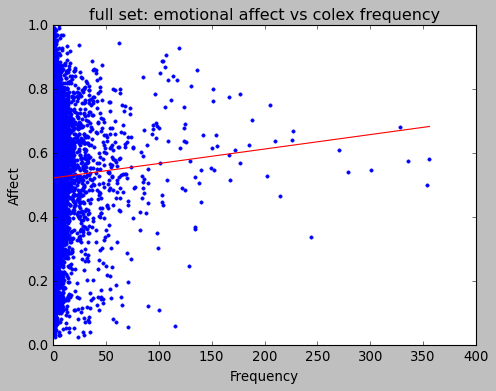

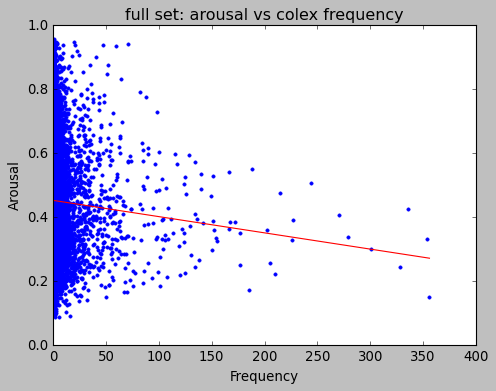

In [38]:
### This cell looks at all the extracted data first ###
 # First Exploration of the complete extraction of data of colexified words and affect and arousal

plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )

plt.subplot(1,2,1)

# This graph plots the frequency of colexification against ratings for emotional affect.

x3, y3 = full_graph[2], full_graph[3]
slope, intercept = np.polyfit(x3.flatten(), y3.flatten(), deg=1)
plt.plot(x3 , y3, '.')
plt.plot(x3, intercept + slope*x3, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Affect')
plt.title("full set: emotional affect vs colex frequency")

plt.show()

plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )
plt.subplot(1,2,2)

# This graph plots the frequency of the colexification against ratings for arousal.
x4, y4 = full_graph_arousal[2], full_graph_arousal[3]
slope, intercept = np.polyfit(x4.flatten(), y4.flatten(), deg=1)
plt.plot(x4 , y4, '.')
plt.plot(x4, intercept + slope*x4, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Arousal')
plt.title("full set: arousal vs colex frequency")

plt.show()

r3, p3 = st.pearsonr(x3, y3)
r4, p4 = st.pearsonr(x4, y4)


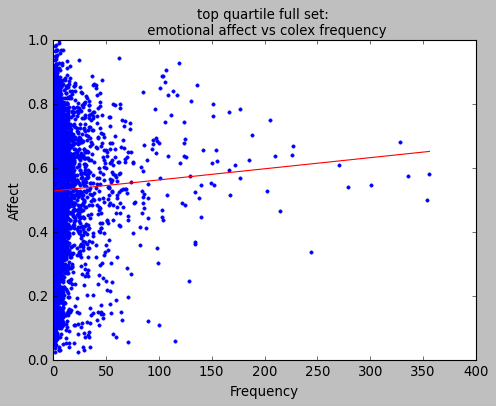

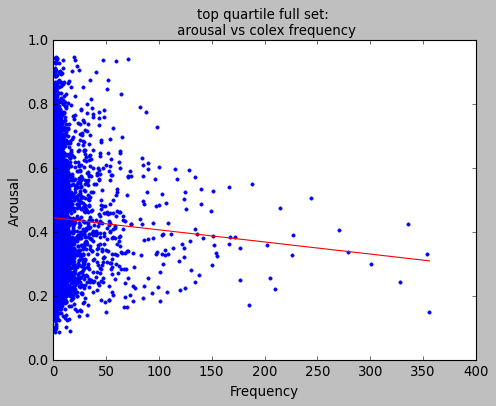

In [39]:
#### Graph exploration 2 ###
plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )

plt.subplot(1,2,1)
# this graph explores the relationship between the top quartile of all the colexified words
# with ratings for emotional affect and the frequency of colexification

x1, y1 = high_graph[2], high_graph[3]
slope, intercept = np.polyfit(x1.flatten(), y1.flatten(), deg=1)
plt.plot(x1 , y1, '.')
plt.plot(x1, intercept + slope*x1, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Affect')
plt.title("top quartile full set: \n emotional affect vs colex frequency", fontsize=12)

plt.show()

plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )
plt.subplot(1,2,2)

# this graph explores the relationship between the top quartile of all the colexified words
# with ratings for arousal and the frequency of colexification

x2, y2 = high_graph_arousal[2], high_graph_arousal[3]
slope, intercept = np.polyfit(x2.flatten(), y2.flatten(), deg=1)
plt.plot(x2 , y2, '.')
plt.plot(x2, intercept + slope*x2, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Arousal')
plt.title("top quartile full set: \n arousal vs colex frequency", fontsize=12)

plt.show()

r1, p1 = st.pearsonr(x1, y1)
r2, p2 = st.pearsonr(x2, y2)



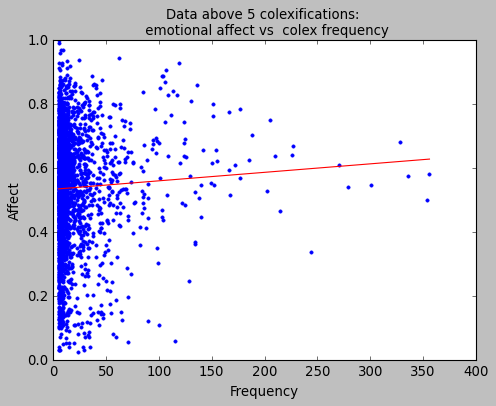

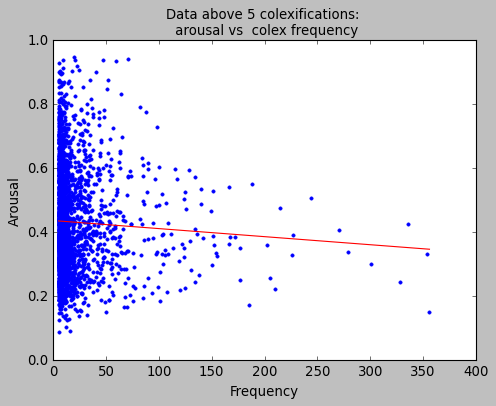

In [40]:
### Graph Exploration 3 ###
plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )

plt.subplot(1,2,1)
# this graph explores the relationship between the top quartile of all the colexified words
# with ratings for emotional affect and the frequency of colexification

x5, y5 = above_graph_affect[2], above_graph_affect[3]
slope, intercept = np.polyfit(x5.flatten(), y5.flatten(), deg=1)
plt.plot(x5 , y5, '.')
plt.plot(x5, intercept + slope*x5, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Affect')
plt.title("Data above 5 colexifications: \n emotional affect vs  colex frequency", fontsize=12)

plt.show()

plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )
plt.subplot(1,2,2)

# this graph explores the relationship between the top quartile of all the colexified words
# with ratings for arousal and the frequency of colexification

x6, y6 = above_graph_arousal[2], above_graph_arousal[3]
slope, intercept = np.polyfit(x6.flatten(), y6.flatten(), deg=1)
plt.plot(x6 , y6, '.')
plt.plot(x6, intercept + slope*x6, 'r', label='fitted line')
plt.xlabel('Frequency')
plt.ylabel('Arousal')
plt.title("Data above 5 colexifications: \n arousal vs  colex frequency", fontsize=12)

plt.show()

r5, p5 = st.pearsonr(x5, y5)
r6, p6 = st.pearsonr(x6, y6)

The next step I looked at the pearson r values:


In [15]:
### Pearson r values ###
pearson_list = [(r3, p3, 'full set emotional affect'),(r4, p4, 'full set arousal'), (r1, p1, 'full set quartile emotional affect '), (r2, p2, 'full set quartile arousal'),(r5, p5, 'colex > 5 emotional affect'), (r6, p6, 'colex > 5 arousal')]
for x in pearson_list:
    print(f"The Pearson correlation between {x[2]} and frequency of colexification is :{format(x[0], '.3f')}")

The Pearson correlation between full set emotional affect and frequency of colexification is :0.025
The Pearson correlation between full set arousal and frequency of colexification is :-0.031
The Pearson correlation between full set quartile emotional affect  and frequency of colexification is :0.036
The Pearson correlation between full set quartile arousal and frequency of colexification is :-0.043
The Pearson correlation between colex > 5 emotional affect and frequency of colexification is :0.046
The Pearson correlation between colex > 5 arousal and frequency of colexification is :-0.049


The next step I test my hypothesis statements:
(1)Is the emotional ratings of paired concepts in the top quarter of colexified
concepts significant from the average of the full set?:

(2)Is the arousal ratings of paired concepts in the top quarter of colexified
concepts significant from the average of the full set?:

In [19]:
###t-tests###

# Do a one sample t-test on the high affect valence,and one on the high arousal

mean_high_affect = np.mean(y1)
mean_high_arousal = np.mean(y2)
mean_full_affect = np.mean(y3)
mean_full_arousal= np.mean(y4)
mean_above_affect= np.mean(y5)
mean_above_arousal= np.mean(y6)


means_list = [('mean_high_affect', y1, mean_high_affect, mean_full_affect), ('mean_high_arousal',y2, mean_high_arousal, mean_full_arousal), ('mean_above_affect', y5,mean_above_affect, mean_full_affect),('mean_above_arousal',y6,mean_above_arousal, mean_full_arousal), ]

for x in means_list:
    t_stat, p_val = st.ttest_1samp(x[1], popmean=x[3])
    std_error = np.std(x[1])/np.sqrt(len(x[1]))
    print(f"The {x[0]} is {format(x[2], '.3f')} \n The test statistic is: {format(t_stat, '.3f')}\n its p-value is: {p_val} \n and the standard error is: {format(std_error, '3f')}")
print(mean_full_arousal, mean_full_affect)

The mean_high_affect is 0.530 
 The test statistic is: 4.314
 its p-value is: 1.6194156311318802e-05 
 and the standard error is: 0.001647
The mean_high_arousal is 0.442 
 The test statistic is: -5.730
 its p-value is: 1.0341512163597579e-08 
 and the standard error is: 0.001499
The mean_above_affect is 0.539 
 The test statistic is: 4.298
 its p-value is: 1.793130728523464e-05 
 and the standard error is: 0.003601
The mean_above_arousal is 0.431 
 The test statistic is: -6.215
 its p-value is: 6.027342587848913e-10 
 and the standard error is: 0.003189
0.4506776707932141 0.5231571654185134


Conclusion:
(1) Hypothesis: The emotional affect ratings from the top quartile of words (n=9883) has a t-value = 4.314 and a p-value of < .001 which means there is
a significant variance from the mean and the null hypothesis is rejected.
The results reveal that I can in fact reject the Null hypothesis and adopt the alternate hypothesis.

(2) Hypothesis: The arousal ratings from the top quartile of words (n=9883) has a t-value = -5.730 and a p-value of < .001 which means there is
a significant variance from the mean and the null hypothesis is rejected.

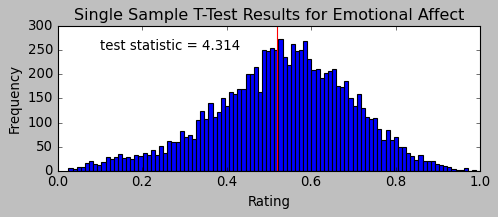

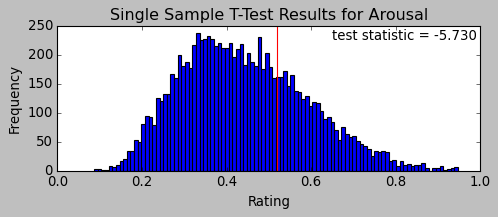

In [42]:


plt.style.use('classic')

fig = plt.figure(figsize=(15,5) )
plt.subplot(2,2,1)
ratings = []

# define the frequency or percentage of observations in each category
freq = y1

# define the mean or expected value
mean = 0.52

# create the histogram
plt.hist(freq, bins=100)

# add a vertical line to show the mean
plt.axvline(mean, color='r')

# add a title and labels to the axes
plt.title('Single Sample T-Test Results for Emotional Affect')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# display the test statistic, p-value, and standard error on the graph
plt.text(0.1, 250, 'test statistic = 4.314', ha='left')
#plt.text(0.6, 55, 'p-value = 1.6194e-05')
#plt.text(0.6, 50, 'standard error = 0.001647')
plt.show()

plt.style.use('classic')
fig = plt.figure(figsize=(15,5) )
plt.subplot(2,2,2)

ratings = []

# define the frequency or percentage of observations in each category
freq = y2

# define the mean or expected value
mean = 0.52

# create the histogram
plt.hist(freq, bins=100)

# add a vertical line to show the mean
plt.axvline(mean, color='r')

# add a title and labels to the axes
plt.title('Single Sample T-Test Results for Arousal')
plt.xlabel('Rating')
plt.ylabel('Frequency')

# display the test statistic, p-value, and standard error on the graph
plt.text(0.65, 225, 'test statistic = -5.730', ha='left')
#plt.text(0.6, 55, 'p-value = 1.6194e-05')
#plt.text(0.6, 50, 'standard error = 0.001647')

# show the plot
plt.show()